<a href="https://colab.research.google.com/github/sameer-gupta18/CNN_Research/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/sanghvirajit/Medical-Image-Classification-using-CNN.git

fatal: destination path 'Medical-Image-Classification-using-CNN' already exists and is not an empty directory.


In [ ]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 49.7 MB/s eta 0:00:00


In [ ]:
device_name='/device:GPU:0'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import tensorflow as tf
import random

In [ ]:
train_dir="/content/Medical-Image-Classification-using-CNN/chest_xray/train/"
test_dir='/content/Medical-Image-Classification-using-CNN/chest_xray/test/'
val_dir='/content/Medical-Image-Classification-using-CNN/chest_xray/val/'

In [ ]:
batch_size = 32
img_height,img_width = 224,224

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

In [ ]:
import cv2

def apply_blur(image):
    random_int = random.random()
    if random_int<=0.4:
      kernel_size = np.random.choice([3, 5, 9, 13])  # Randomly choose a blur level
    else:
      kernel_size = 1
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split = 0.10,
    preprocessing_function = apply_blur
)

In [ ]:
# val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',  # Binary classification
    shuffle=True,
    subset="training",
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset="validation",
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode='binary'
)


Found 4695 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

In [ ]:
model.compile(
    optimizer=Adam(learning_rate = 0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

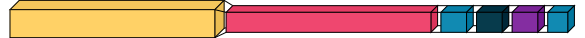

In [ ]:
import visualkeras
visualkeras.layered_view(model)

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,113,537 (91.99 MB)

 Trainable params: 24,059,905 (91.78 MB)

 Non-trainable params: 53,632 (209.50 KB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
with tf.device(device_name):
  history = model.fit(
      train_generator,
      # steps_per_epoch=train_generator.samples // batch_size,
      epochs=20,  # You can increase the number of epochs based on your dataset
      validation_data=val_generator,
      # validation_steps = val_generator.samples // batch_size,
      callbacks = [early_stopping, reduce_lr]
  )

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


147/147 ━━━━━━━━━━━━━━━━━━━━ 169s 779ms/step - accuracy: 0.8365 - loss: 0.3915 - val_accuracy: 0.7428 - val_loss: 1.5579 - learning_rate: 1.0000e-04
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 92s 600ms/step - accuracy: 0.9329 - loss: 0.2327 - val_accuracy: 0.7428 - val_loss: 1.6714 - learning_rate: 1.0000e-04
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 92s 602ms/step - accuracy: 0.9552 - loss: 0.1537 - val_accuracy: 0.7428 - val_loss: 0.9124 - learning_rate: 1.0000e-04
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 92s 601ms/step - accuracy: 0.9725 - loss: 0.0995 - val_accuracy: 0.7428 - val_loss: 1.4221 - learning_rate: 1.0000e-04
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 92s 600ms/step - accuracy: 0.9628 - loss: 0.1450 - val_accuracy: 0.7428 - val_loss: 1.4765 - learning_rate: 1.0000e-04
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.9699 - loss: 0.1048
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
147/147 ━━━━━━━━━━━━━━━━━━━━ 92s 601ms/step - accu

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test accuracy: {test_acc * 100:.2f}%")

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8701 - loss: 0.3377
Test accuracy: 89.47%


In [ ]:
model.save('pneumonia_classification_model_resnet.h5')

In [ ]:
# from google.colab import files
# files.download('pneumonia_classification_model_resnet.h5')

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

img_path = '/content/Medical-Image-Classification-using-CNN/chest_xray/test/NORMAL/IM-0005-0001.jpeg'
img = load_img(img_path, target_size = (224,224))
img_array = img_to_array(img)
img_array = img_array/255.0
img_array = np.expand_dims(img_array, axis = 0)

In [ ]:
prediction = model.predict(img_array)
if prediction[0][0]>0.5:
  print('Pneumonia')
else:
  print('Normal')

print(prediction[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Normal
0.00022281328


In [ ]:
import cv2
def apply_blur(image,kernel_size):
  return cv2.GaussianBlur(image,(kernel_size,kernel_size),0)

(224, 224, 3)


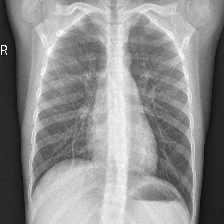

(224, 224, 3)


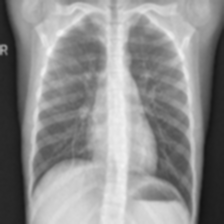

In [ ]:
from google.colab.patches import cv2_imshow

val = '/content/Medical-Image-Classification-using-CNN/chest_xray/test/NORMAL/IM-0003-0001.jpeg'
img = load_img(val, target_size = (224,224))
img_array = img_to_array(img)
img_array = img_array/255.0
print(img_array.shape)
cv2_imshow(img_array*255)

img_array = apply_blur(img_array,5)
img_array = np.uint8(img_array * 255)
img_array = img_array/255.0
print(img_array.shape)
cv2_imshow(img_array*255)

img_array = np.expand_dims(img_array, axis = 0)



In [ ]:
import os
import time
import psutil
sample_count = 0

predicted_classes = []
actual_classes = []
times=[]
memorys = []
confidence = []
losses = []
paths = []

for label in os.listdir(test_dir):
  class_folder_path = os.path.join(test_dir,label)

  if os.path.isdir(class_folder_path):
    for image_name in os.listdir(class_folder_path):
      image_path = os.path.join(class_folder_path, image_name)
      img = load_img(image_path, target_size = (224,224))
      img_array = img_to_array(img)
      img_array = img_array/255.0
      img_array = apply_blur(img_array,13)
      img_array = np.uint8(img_array * 255)
      img_array = img_array/255.0
      img_array = np.expand_dims(img_array, axis = 0)


      start_time = time.time()
      memory_before = psutil.Process().memory_info().rss

      prediction = model.predict(img_array)

      memory_after = psutil.Process().memory_info().rss
      end_time = time.time()

      time_taken = end_time - start_time
      memory_usage = memory_after - memory_before
      if(prediction[0][0]>0.5):
        predicted_class = 'PNUEMONIA'
      else:
        predicted_class = 'NORMAL'

      if label == 'PNEUMONIA':
        label_n = np.array([1])
      else:
        label_n = np.array([0])
      label_n = label_n.reshape(1, 1)
      loss = tf.keras.losses.binary_crossentropy(label_n,prediction, from_logits=False)


      predicted_classes.append(predicted_class)
      actual_classes.append(label)
      paths.append(image_path)
      times.append(time_taken)
      memorys.append(memory_usage)
      confidence.append(prediction[0][0])
      losses.append(loss)

print(confidence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

In [ ]:
losses_updated = []
for val in losses:
  losses_updated.append(val.numpy()[0])

In [ ]:
import pandas as pd

resnet_df = pd.DataFrame({
    'path':paths,
    'actual_class':actual_classes,
    'predicted_class':predicted_classes,
    'weighted_val':confidence,
    'loss':losses_updated,
    'memory_usage':memorys,
    'time':times
})

print(resnet_df)

                                                  path actual_class  \
0    /content/Medical-Image-Classification-using-CN...       NORMAL   
1    /content/Medical-Image-Classification-using-CN...       NORMAL   
2    /content/Medical-Image-Classification-using-CN...       NORMAL   
3    /content/Medical-Image-Classification-using-CN...       NORMAL   
4    /content/Medical-Image-Classification-using-CN...       NORMAL   
..                                                 ...          ...   
619  /content/Medical-Image-Classification-using-CN...    PNEUMONIA   
620  /content/Medical-Image-Classification-using-CN...    PNEUMONIA   
621  /content/Medical-Image-Classification-using-CN...    PNEUMONIA   
622  /content/Medical-Image-Classification-using-CN...    PNEUMONIA   
623  /content/Medical-Image-Classification-using-CN...    PNEUMONIA   

    predicted_class  weighted_val      loss  memory_usage      time  
0         PNUEMONIA      0.513405  0.720323        200704  0.070251  
1      

In [ ]:
from google.colab import files
resnet_df.to_csv('resnet_net_data.csv',index=False)
files.download('resnet_net_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, f1_score
import seaborn as sns

In [ ]:
predicted_classes_binary = []
for name in predicted_classes:
  if name=="NORMAL":
    predicted_classes_binary.append(0)
  else:
    predicted_classes_binary.append(1)

In [ ]:
# resnet_net_training = pd.DataFrame({
#     'accuracy':history.history['accuracy'],
#     'loss':history.history['loss'],
#     'val_accuracy':history.history['val_accuracy'],
#     'val_loss':history.history['val_loss'],
#     'lr':history.history['learning_rate']
# })

# resnet_net_training.to_excel('efficient_net.xlsx',index=False,engine='openpyxl')
# files.download('efficient_net.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
actual_classes_binary = []
for name in actual_classes:
  if name=="NORMAL":
    actual_classes_binary.append(0)
  else:
    actual_classes_binary.append(1)

In [ ]:
threshold = 0
tpr = []
fpr = []
while threshold<=1:
  preds = []
  for data in confidence:
    if data>threshold:
      preds.append(1)
    else:
      preds.append(0)
  tn, fp, fn, tp = confusion_matrix(actual_classes_binary,preds).ravel()

  true_positive = tp/ (tp+fn)
  false_positive = fp / (fp + tn)

  tpr.append(true_positive)
  fpr.append(false_positive)
  threshold +=0.001

print(tpr)
print(fpr)

fpr.append(0)
tpr.append(0)

[1.0, 1.0, 1.0, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.9974358974358974, 0.99

In [ ]:
rates=pd.DataFrame({
    'tpr':tpr,
    'fpr':fpr
})
rates.to_excel('rates.xlsx',index=False,engine='openpyxl')
files.download('rates.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

accuracy = accuracy_score(actual_classes_binary,predicted_classes_binary)
precision = precision_score(actual_classes_binary,predicted_classes_binary, average='binary')  # Use 'binary' for binary classification
recall = recall_score(actual_classes_binary,predicted_classes_binary, average='binary')
f1 = f1_score(actual_classes_binary,predicted_classes_binary, average='binary')

# Print the results with high precision
print(f"Accuracy: {accuracy:.5f}")
print(f"Precision: {precision:.5f}")
print(f"Recall: {recall:.5f}")
print(f"F1 Score: {f1:.5f}")

Accuracy: 0.90545
Precision: 0.87699
Recall: 0.98718
F1 Score: 0.92883


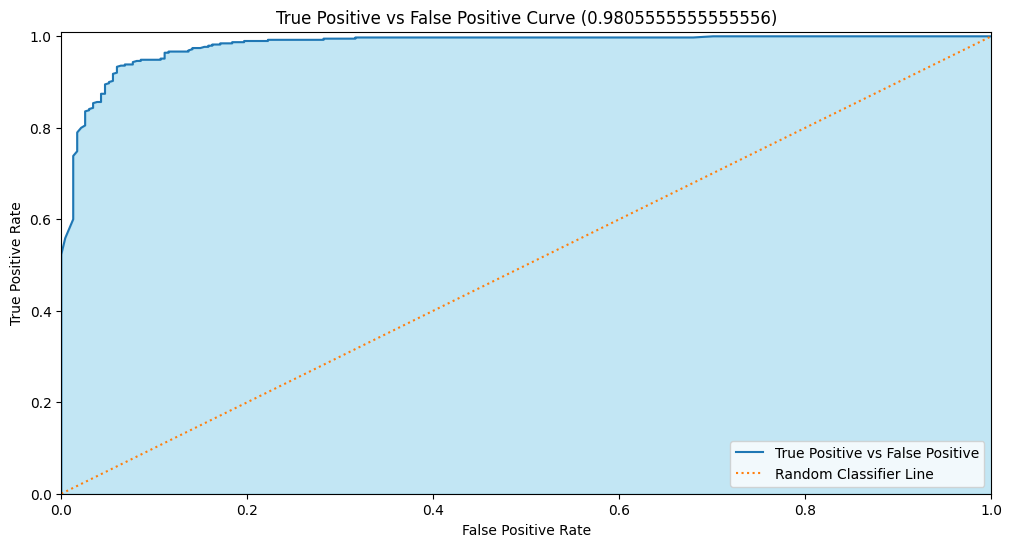

0.9805555555555556

In [ ]:
plt.figure(figsize=(12,6))

x= np.linspace(0,1,100)
y = x

plt.plot(fpr,tpr, label='True Positive vs False Positive')
plt.plot(x,y,label='Random Classifier Line',linestyle=':')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim(0,1.0)
plt.ylim(0,1.01)

plt.fill_between(fpr,tpr, color="skyblue",alpha=0.5)
area = np.trapz(tpr,fpr)
plt.title(f'True Positive vs False Positive Curve ({-area})')
plt.legend()
plt.show()



area*-1

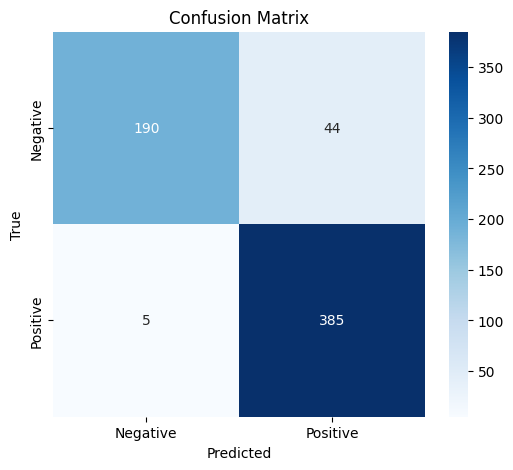

In [ ]:
cm = confusion_matrix(actual_classes_binary,predicted_classes_binary)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

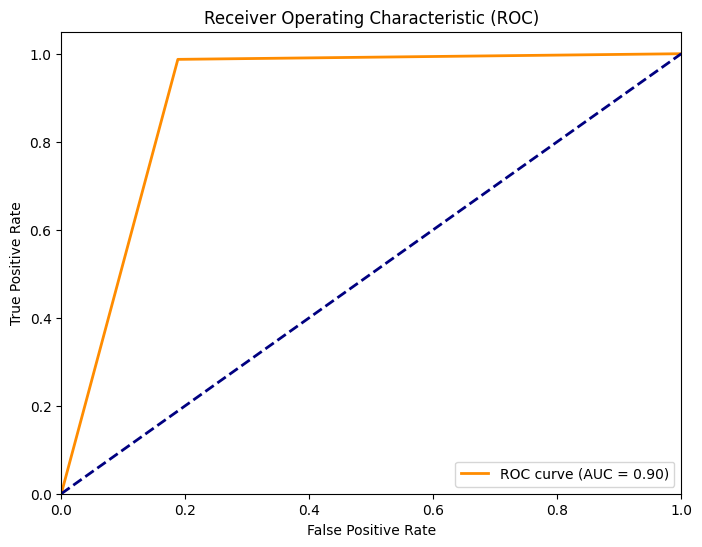

In [ ]:
fpr, tpr, thresholds = roc_curve(actual_classes_binary,predicted_classes_binary)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

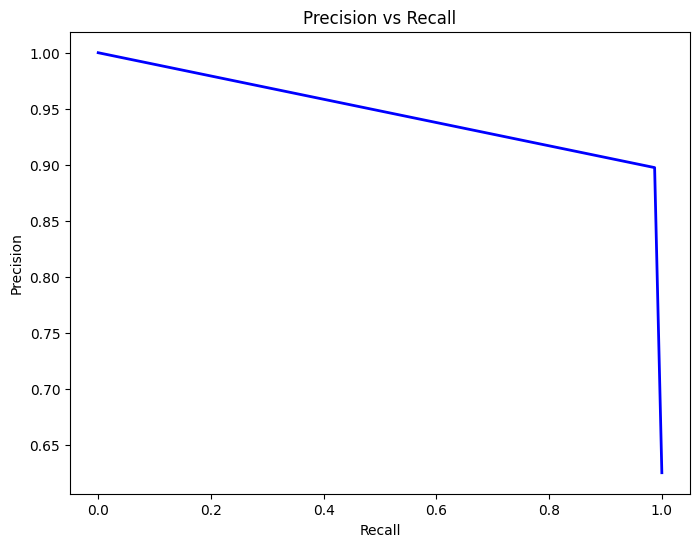

In [ ]:
precision, recall, _ = precision_recall_curve(actual_classes_binary,predicted_classes_binary)

# Plot precision vs recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs Recall')
plt.show()

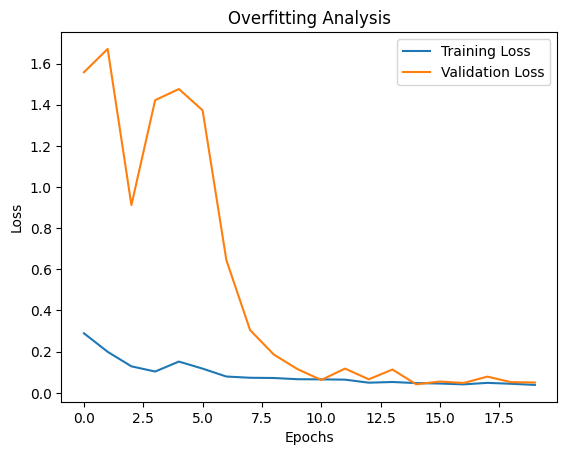

In [ ]:
# val_loss=[]
# for loss in history.history['val_loss']:
#   # if loss>1000:
#   #   val_loss.append(loss/1000)
#   # elif loss >100:
#   #   val_loss.append(loss/100)
#   # elif loss>10:
#   #   val_loss.append(loss/10)
#   # else:
#     val_loss.append(loss)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Overfitting Analysis')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

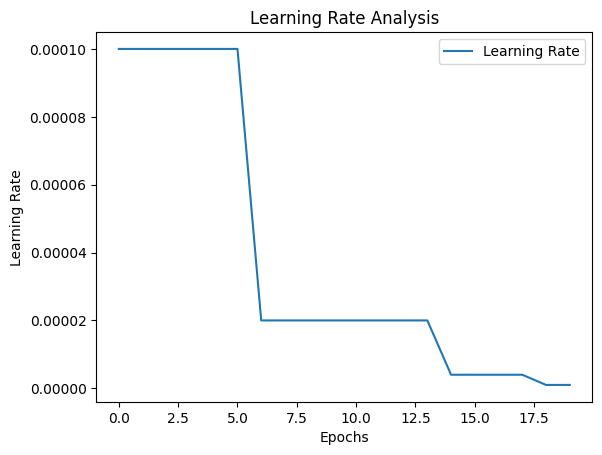

In [ ]:
plt.plot(history.history['learning_rate'], label='Learning Rate')
plt.title('Learning Rate Analysis')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.show()

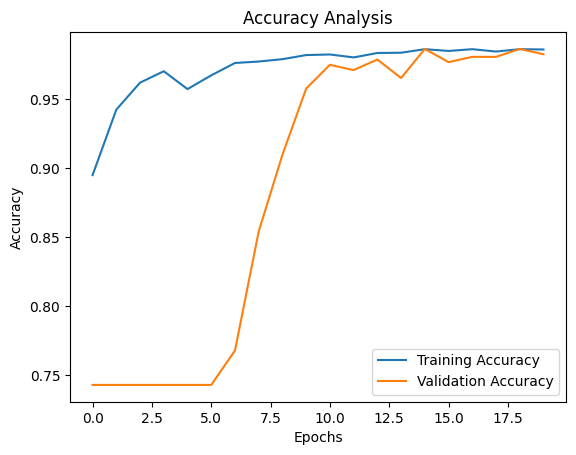

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Analysis')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()